In [ ]:
import pathlib, itertools as it, networkx as nx, numpy as np, pandas as pd, jax as jx, jax.numpy as jnp
path = pathlib.Path('/content')

def init(seed=0, n_nodes=763, m_connect=None, n_index=3, alpha=0.48, beta=0.0325, reinfect=0.0):
    try:
        G = nx.barabasi_albert_graph(n_nodes, m_connect, seed=seed)
        G.name = f"barabasi_albert_graph_{n_nodes}_{m_connect}"
    except:
        G = nx.complete_graph(n_nodes)
        G.name = f'complete_graph_{n_nodes}'
    G.seed = seed
    G.n_nodes = n_nodes
    G.m_connect = m_connect
    G.n_index = n_index

    D = jnp.array(G.degree).T
    G.deg = D[1]
    G.key, *subkeys = jx.random.split(jx.random.PRNGKey(seed), 2)
    # idx        = jx.random.choice(subkeys[0], D[0], p=D[1], shape=[n_index], replace=False)  # draw idx randomly with preference for high degree
    idx        = G.deg.argsort()[-n_index:]  # draw idx deterministically as highest degree
    G.state    = jnp.zeros(n_nodes, dtype=jnp.uint8).at[idx].set(1)
    G.hist     = [G.state.copy()]
    G.nbr      = jnp.array(nx.to_numpy_matrix(G, dtype='bool'))
    G.alpha    = jnp.full(n_nodes, alpha, dtype='float32')
    G.beta     = jnp.full(n_nodes, beta, dtype='float32')
    G.reinfect = jnp.full(n_nodes, reinfect, dtype='float32')
    return G

@jx.jit
def evolve(key, state, beta, nbr, alpha, reinfect):
    """
    compute spread and recovery
    A susceptible node becomes infected iff ANY of its infected neighbors successfully spread to it.
    This formulation will require us to draw a random number for EACH infected neighbor
    We convert this into a more efficient linear algebra formulations via the steps below.
    As we learned in intro stats, its much more efficient to rephrase this statements as:
    A susceptible node stay susceptible iff NONE of its infected neighbors successfully spread to it:
    This formulation allows us to draw ONE random number and compare to 1 - (1-beta_i) ** (# infected neighbors)
    We also allow possibility of reinfection by multiplying beta for all recovered nodes by "reinfect"
    To prevent reinfection, simply set infect = 0 (default)
    """
    key, *subkeys = jx.random.split(key, 3)
    S = state==0
    I = ~S
    N = nbr * I
    gamma = 1 - (1 - beta) ** N.sum(axis=1)
    # gamma = 1 - jnp.prod((1 - beta[:,None]) * N + ~N, axis=1)  # alternate form if we ever introduce edges with weights
    SI = jx.random.uniform(subkeys[0], state.shape) < gamma  # indicator of S -> I transition
    IR = jx.random.uniform(subkeys[1], state.shape) < alpha  # indicator of I -> R transition
    state = S*SI + I*(1+IR)  # compute new state after transitions
    R = state==2  # find recovered
    beta *= (R*reinfect + ~R)  # reduce susceptibility of recovered by factor of reinfect
    state %= 2  # recovered become susceptible
    return key, state, beta

def main(n_trials=25, **kwargs):
    I = []
    for k in range(n_trials * 10):
        print(len(I), end=', ')
        G = init(seed=k, **kwargs)
        for step in range(n_steps):
            G.key, G.state, G.beta = evolve(G.key, G.state, G.beta, G.nbr, G.alpha, G.reinfect)
            G.hist.append(G.state.copy() + 2*(G.beta==0))
        G.hist = np.array(G.hist)
        i = (G.hist==1).sum(axis=1)
        if i[2] > 0:  # reject trial if eradicates too early
            I.append(i)
        if len(I) >= n_trials:
            break
    G.I_pred = np.array(I)
    G.rmse = np.sqrt(np.nanmean((G.I_pred - I_true)**2))
    print('\n', G.name, G.rmse, kwargs)
    return G

n_nodes = 763
I_true = np.array([3, np.nan, 25, 75, 227, 296, 285, 236, 192, 126, 71, 28, 11, 7])
n_steps = len(I_true)-1

In [ ]:
import matplotlib.pyplot as plt, bokeh as bk, bokeh.plotting, ipywidgets as widgets, plotly.express as px
from scipy.interpolate import make_interp_spline, CubicSpline
from IPython.display import HTML
bk.io.output_notebook()

def spliner(x, y):
    spline = make_interp_spline(x, y)
    # spline = CubicSpline(x, y)
    xx = np.linspace(x.min(), x.max(), 500)
    return xx, spline(xx)

def plot_fit(G, alpha=0.1, filename=None):
    x = np.arange(n_steps+1)+1
    y = I_true
    y[1] = 7
    plt.plot(*spliner(x, y), alpha=1.0, c='red' , label='obs', linewidth=3)
    y = G.I_pred.mean(axis=0)
    plt.plot(*spliner(x, y), alpha=1.0, c='blue', label='pred', linewidth=3)
    for y in G.I_pred:
        plt.plot(*spliner(x, y), alpha=alpha, c='blue')
    plt.title(f'{G.name}, α={G.alpha.max():.3}, β={G.beta.max():.3}')
    plt.xlabel('Day')
    plt.ylabel('Infected')
    plt.legend()
    if filename:
        plt.savefig(filename)
    plt.show()

def plot_errors(errors, x='alpha', y='beta', z='rmse'):
    fig = px.density_contour(errors, x=x, y=y, z=z, histfunc='avg',
        range_x = (errors[x].min(), errors[x].max()),
        range_y = (errors[y].min(), errors[y].max()),
        labels = {'alpha':'α', 'beta':'β'}
    )
    fig.update_layout(title_text=z.upper(), title_x=0.5, title_y=0.92)
    fig.update_traces(contours_coloring="fill", colorscale='deep')
    fig.show()
    display(errors.sort_values(z))

def animate(G, palette=bk.palettes.Plasma3):
    if not hasattr(G, 'layout'):
        G.layout = nx.spring_layout(G, seed=42)
    clr = {node: {str(step): palette[state] for step, state in enumerate(y)} for node, y in enumerate(G.hist.T)}

    nx.set_node_attributes(G, clr)
    hover=[('index', '@index'), ('degree', '@degree')]
    p = bk.plotting.figure(tooltips=hover, height=300, width=300)
    G.fig = bk.plotting.from_networkx(G, G.layout)
    G.fig.node_renderer.glyph = bk.models.Circle(size=5, fill_color='0')
    G.fig.edge_renderer.glyph = bk.models.MultiLine(line_alpha=0.5, line_width=0.2)
    p.renderers.append(G.fig)
    bk.plotting.show(p, notebook_handle=True)
    def update(step):
        G.fig.node_renderer.glyph.fill_color = str(step)
        bk.io.push_notebook()
    opts = {'value':0, 'min':0, 'max':len(G.hist)-1, 'step':1, 'interval':500}
    slider = widgets.IntSlider(**opts)
    play = widgets.Play(**opts)
    display(HTML('''<link rel="stylesheet" href="https://stackpath.bootstrapcdn.com/font-awesome/4.7.0/css/font-awesome.min.css"> ''')) # https://stackoverflow.com/questions/62137006/icon-for-ipywidgets-button-not-working-in-google-colab
    display(slider)
    widgets.jslink((play, 'value'), (slider, 'value'))
    widgets.interact(update, step=play)

def make_plots(G, **kwargs):
    plot_fit(G, filename=path /f'{G.name}_fit.png', **kwargs)
    errors = pd.read_csv(path /f'{G.name}_fine.csv')
    plot_errors(errors)
    return G


0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 
 barabasi_albert_graph_763_100 29.65530547570102 {'n_nodes': 763, 'm_connect': 100, 'n_index': 3, 'alpha': 0.45, 'beta': 0.0108, 'reinfect': 0.0}


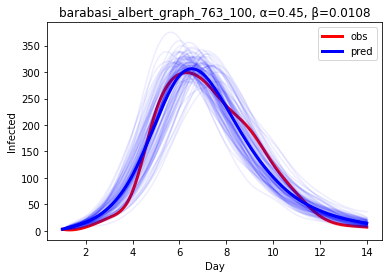

,Unnamed: 0,alpha,beta,m_connections,index_cases,graph,rmse
0,1053,0.450,0.0108,100,3,barabasi_albert_graph_100,30.782363
1,1054,0.450,0.0110,100,3,barabasi_albert_graph_100,30.887015
2,853,0.440,0.0108,100,3,barabasi_albert_graph_100,30.975052
3,954,0.445,0.0110,100,3,barabasi_albert_graph_100,31.020341
4,953,0.445,0.0108,100,3,barabasi_albert_graph_100,31.101818
...,...,...,...,...,...,...,...
2097,1900,0.495,0.0002,100,3,barabasi_albert_graph_100,161.777934
2098,1600,0.480,0.0002,100,3,barabasi_albert_graph_100,161.777934
2095,2000,0.500,0.0002,100,3,barabasi_albert_graph_100,161.777934
2096,1800,0.490,0.0002,100,3,barabasi_albert_graph_100,161.777934


In [ ]:
# kwargs = {'n_nodes':763, 'm_connect':None, 'n_index':3, 'alpha':0.48, 'beta':0.00325, 'reinfect':0.0, 'n_trials':100}
kwargs = {'n_nodes':763, 'm_connect':100 , 'n_index':3, 'alpha':0.45, 'beta':0.0108 , 'reinfect':0.0, 'n_trials':100}
G = main(**kwargs)
make_plots(G, alpha=0.07)


In [ ]:
animate(G)

IntSlider(value=0, max=13)

interactive(children=(Play(value=0, description='step', interval=500, max=13), Output()), _dom_classes=('widge…

In [ ]:
param_grid = {
    'alpha': np.linspace(0.4, 0.5 , 21),
    'beta' : np.linspace(0.0, 0.02, 101)[1:],
    'm_connections': [100],
    'index_cases': [3],
    'reinfect': [0.0],
}
param_grid = [dict(zip(param_grid.keys(), x)) for x in it.product(*param_grid.values())]

for k, kwargs in enumerate(param_grid):
    G = main(n_trials=10, **kwargs)
    kwargs['graph'] = G.name
    kwargs['rmse'] = G.rmse

df = pd.DataFrame(param_grid).sort_values('rmse')
df.to_csv(path / f'{G.name}_fine.csv')
plot_errors(df)

count    763.00000
mean     173.78768
std       77.26268
min      100.00000
25%      119.00000
50%      149.00000
75%      193.00000
max      446.00000
dtype: float64

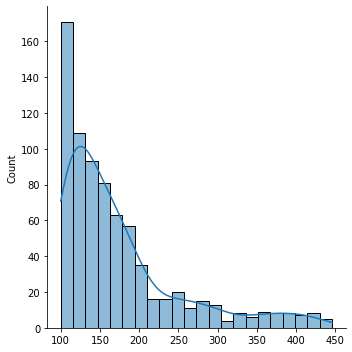

In [ ]:
import seaborn as sns
deg = pd.Series([x[1] for x in G.degree])
sns.displot(deg, kde=True)
display(deg.describe())